In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer
import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.test.utils import get_tmpfile

In [5]:
import re

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [7]:
train = pd.read_json('data/new_modified_train.json').reset_index().drop(columns={'index'})

In [8]:
test = pd.read_json('data/new_modified_test.json').reset_index().drop(columns={'index'})

In [9]:
train_len = len(train)
test_len = len(test)
train_len, test_len

(49165, 74659)

In [10]:
len(train[train['interest_level'] == 'low']), len(train[train['interest_level'] == 'medium']), len(train[train['interest_level'] == 'high'])

(34108, 11222, 3835)

In [11]:
y = train['interest_level']

## attrs & derived attrs

In [12]:
def list_to_string(flist):
    string = ' '.join(flist)
    return string

In [13]:
def extract_description(df):
    classifier = {
        "positive":("beautiful","great",'luxury'),
        "apartment": ("apartment","building"),
        "security": ("access", "doorman", "in_super"),
        "elevator": ("elevator"),
        "stainless": ("stainless"),
        "steel'": ("steel"),
        "dishwasher": ("dishwasher"),
        "good floor": ("granite","marble"),
        "renovated": ("renovated")
    }

    def search_desc(desc):
        return lambda s: int(any([x in s for x in desc]))

    desc = df["description"]
    for key in classifier:
        df['desc_'+key] = desc.apply(search_desc(classifier[key]))

    return df

In [14]:
def extract_features(df):
    classifier = {
        "dogs": ("dogs", "dog"),
        "cats": ("cats", "cat"),
        "allowed":("allowed","allow"),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "security": ("concierge", "doorman", "housekeep", "in_super"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training","wheelchair"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking"),
        "hardwood": ("hardwood"),
        "utilities": ("utilities", "heat water", "water included","garden",'Dishwasher',)
    }

    def search_feature(feature):
        return lambda s: int(any([x in s for x in feature]))

    features = df["features"].apply(list_to_string)   # convert features to string
    features = features.str.lower()
    for key in classifier:
        df['feature_'+key] = features.apply(search_feature(classifier[key]))

    return df

In [15]:
data = train[['distance_subway', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 'manager_id_num', 'photo_num', 'price', 'interest_level', 'features', 'description']]
test_data = test[['distance_subway', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 'manager_id_num', 'photo_num', 'price', 'features', 'description']]

In [16]:
# data = train[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'manager_id_num', 'photo_num', 'price', 'interest_level', 'features', 'description']]
# test_data = test[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'manager_id_num', 'photo_num', 'price', 'features', 'description']]

In [17]:
X_init = data.drop(columns={'interest_level', 'features', 'description'})
test_init = test_data.drop(columns={'features', 'description'})

In [18]:
init_scaler = StandardScaler().fit(X_init)
X_init_sc = init_scaler.transform(X_init)
test_init_sc = init_scaler.transform(test_init)

In [19]:
LRscores_train = []
LRscores_valid = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_init_sc,y):
    X_train = X_init_sc[train_index]
    X_valid = X_init_sc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    lr0 = LogisticRegression(penalty='l2', C=10.0, solver='sag', multi_class='multinomial', max_iter=500)
    lr0.fit(X_train, y_train)
    LRscores_train.append(lr0.score(X_train, y_train))
    LRscores_valid.append(lr0.score(X_valid, y_valid))
print(np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

0.6924133021458355 0.6922200752567884


[0.6943964202176345,
 0.699583036713109,
 0.6828028068748093,
 0.6912437709752873,
 0.6930743415031018]

In [20]:
pr0 = lr0.predict_proba(test_init_sc)

In [21]:
data = extract_features(data)
data = extract_description(data)

/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
X_attr = data.drop(columns={'interest_level', 'features', 'description'})

In [23]:
test_data = extract_description(test_data)
teat_data = extract_features(test_data)

/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
test_attr = test_data.drop(columns={'features', 'description'})

In [25]:
scaler = StandardScaler().fit(X_attr)

In [26]:
X_sc = scaler.transform(X_attr)
test_attr_sc = scaler.transform(test_attr)

In [68]:
LRscores_train = []
LRscores_valid = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_sc,y):
    X_train = X_sc[train_index]
    X_valid = X_sc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    lr1 = LogisticRegression(penalty='l2', C=0.4, solver='sag', multi_class='multinomial', max_iter=500)
    lr1.fit(X_train, y_train)
    LRscores_train.append(lr1.score(X_train, y_train))
    LRscores_valid.append(lr1.score(X_valid, y_valid))
print(np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6954388284348623 0.6953727244991356


[0.6961252923827926,
 0.7014136072409234,
 0.6915488660632564,
 0.6910403742499746,
 0.6967354825587309]

In [29]:
pr1_train = lr1.predict_proba(X_sc)
pr1 = lr1.predict_proba(test_attr_sc)

## feature text 

In [30]:
feat_corpus = list(train['clean_feat']) + list(test['clean_feat'])
text_vector = TfidfVectorizer(min_df=2, max_features=190, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
text_vector.fit(feat_corpus)
X_text = text_vector.transform(train['clean_feat'])
test_text = text_vector.transform(test['clean_feat'])

In [31]:
LRscores_train = []
LRscores_valid = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_text,y):
    X_train = X_text[train_index]
    X_valid = X_text[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    lr2 = LogisticRegression(penalty='l2', C=10.0, tol=0.0001, solver='sag', multi_class='multinomial', max_iter=500)
    lr2.fit(X_train, y_train)
    LRscores_train.append(lr2.score(X_train, y_train))
    LRscores_valid.append(lr2.score(X_valid, y_valid))
print(np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

0.696903284857114 0.6958201972948236


[0.6965320858334181,
 0.7040577646699888,
 0.6860571544798129,
 0.6950066103935727,
 0.6974473710973254]

In [32]:
pr2_train = lr2.predict_proba(X_text)
pr2 = lr2.predict_proba(test_text)

## doc2vec 

In [33]:
def clean_text(text):
    # acronym
    text = re.sub(r"br\s", "bedroom", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"cannot", "can not ", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve ", " have ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    # symbol
    text = re.sub(r"&", " and ", text)
    text = re.sub(r"\|", " or ", text)
    text = re.sub(r"=", " equal ", text)
    text = re.sub(r"\+", " plus ", text)
    text = re.sub(r"\$", " dollar ", text)
    # others
    text = re.sub(r"[^a-zA-Z]", " ",text)
    # extra \s
    text = " ".join(text.split())

    return text

In [34]:
train_doc = train[['description']]
test_doc = test[['description']]
data_doc = pd.concat([train_doc, test_doc], axis=0)

In [35]:
data_doc['description_words'] = data_doc['description'].apply(clean_text)

In [36]:
TaggededDocument = gensim.models.doc2vec.TaggedDocument

In [37]:
def addTag(descr):
    train=[]
    for i, doc in enumerate(descr):
        word_list = doc.split(' ')
        document = TaggededDocument(word_list, tags=[i])
        train.append(document)
    return train

In [38]:
taggedDoc = addTag(list(data_doc['description_words']))

In [39]:
doc2vec = Doc2Vec(taggedDoc, vector_size=120, min_count = 10, window = 5, sample = 1e-5, workers=4)
doc2vec.train(taggedDoc, total_examples=doc2vec.corpus_count, epochs=10)

In [40]:
train_indList = list(range(0,train_len))
test_indList = list(range(train_len, train_len + test_len))
X_doc = doc2vec[train_indList]
test_doc = doc2vec[test_indList]

In [42]:
LRscores_train = []
LRscores_valid = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_text,y):
    X_train = X_doc[train_index]
    X_valid = X_doc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    lr3 = LogisticRegression(penalty='l2', C=0.4, solver='sag', multi_class='multinomial', max_iter=500)
    lr3.fit(X_train, y_train)
    LRscores_train.append(lr3.score(X_train, y_train))
    LRscores_valid.append(lr3.score(X_valid, y_valid))
print(np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

0.6930743415031018 0.6926065290348825


[0.6919556595138818,
 0.7009051154276417,
 0.6850401708532493,
 0.6911420726126309,
 0.693989626767009]

In [43]:
pr3_train = lr3.predict_proba(X_doc)
pr3 = lr3.predict_proba(test_doc)

## vote / ensemble 

In [44]:
temp = 0.4*pr1 + 0.4*pr2 + 0.2*pr3

In [45]:
train_probs = pd.DataFrame({'pr1_h': pd.Series(pr1_train[:,0]), 'pr1_l': pd.Series(pr1_train[:,1]), 'pr1_m': pd.Series(pr1_train[:,2]),
                                         'pr2_h': pd.Series(pr2_train[:,0]), 'pr2_l': pd.Series(pr2_train[:,1]), 'pr2_m': pd.Series(pr2_train[:,2]),
                                         'pr3_h': pd.Series(pr3_train[:,0]), 'pr3_l': pd.Series(pr3_train[:,1]), 'pr3_m': pd.Series(pr3_train[:,2])})

In [46]:
ens_X = train_probs

In [48]:
LRscores_train = []
LRscores_valid = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(ens_X,y):
    X_train = ens_X.iloc[train_index]
    X_valid = ens_X.iloc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    lr = LogisticRegression(penalty='l2', C=10.0, solver='sag', multi_class='multinomial', max_iter=500)
    lr.fit(X_train, y_train)
    LRscores_train.append(lr.score(X_train, y_train))
    LRscores_valid.append(lr.score(X_valid, y_valid))
print(np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

0.7010474931353606 0.7013119088782671


[0.6987694498118581,
 0.7085324926268687,
 0.6986677514492017,
 0.7001932268890471,
 0.7003966236143598]

In [49]:
test_probs = pd.DataFrame({'pr1_h': pd.Series(pr1[:,0]), 'pr1_l': pd.Series(pr1[:,1]), 'pr1_m': pd.Series(pr1[:,2]),
                                        'pr2_h': pd.Series(pr2[:,0]), 'pr2_l': pd.Series(pr2[:,1]), 'pr2_m': pd.Series(pr2[:,2]),
                                        'pr3_h': pd.Series(pr3[:,0]), 'pr3_l': pd.Series(pr3[:,1]), 'pr3_m': pd.Series(pr3[:,2])})

In [50]:
ens_pro = lr.predict_proba(test_probs)

## all together 

In [51]:
new_train = pd.read_json('data/new_modified_train.json').reset_index().drop(columns={'index'})

In [52]:
new_test = pd.read_json('data/new_modified_test.json').reset_index().drop(columns={'index'})

In [53]:
new_train_ = new_train.drop(columns = {'distance_subway', 'diff_rooms', 'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [54]:
new_test_ = new_test.drop(columns = {'distance_subway', 'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [55]:
new_X = new_train_.drop(columns={'interest_level'})
new_y = new_train_['interest_level']

In [56]:
new_scaler = StandardScaler().fit(new_X)
new_X_sc = new_scaler.transform(new_X)
new_test_sc = new_scaler.transform(new_test_)

In [57]:
def cm_plot(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = ['high','low','medium'])
    cm = pd.DataFrame(cm,columns=['high','low','medium'],index = ['high','low','medium'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='Reds', fmt='.20g', linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig('cm.png',dpi=800)

scores on train and valid:  0.6996999898301637 0.6971626156818875
recalls: [0.37388529416128796, 0.37766206149281834, 0.3777930804134632, 0.3792332824751002, 0.3879148527705742]
precisions: [0.5132043122875246, 0.5483742726069089, 0.5379756188650556, 0.5212794960818277, 0.4915801076961464]


[0.6959218956574799,
 0.7102613647920268,
 0.6911420726126309,
 0.6927692464151327,
 0.6957184989321672]

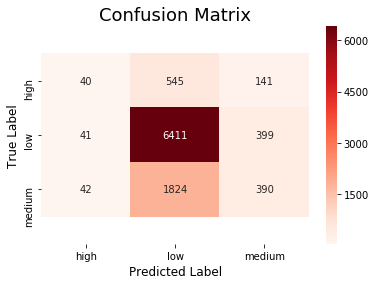

In [58]:
LRscores_train = []
LRscores_valid = []
precision = []
recall = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(new_X_sc, new_y):
    X_train = new_X_sc[train_index]
    X_valid = new_X_sc[valid_index]
    y_train = new_y.iloc[train_index]
    y_valid = new_y.iloc[valid_index]
    new_lr = LogisticRegression(penalty='l2', C=10.0, solver='sag', multi_class='multinomial', max_iter=500)
    new_lr.fit(X_train, y_train)
    LRscores_train.append(new_lr.score(X_train, y_train))
    LRscores_valid.append(new_lr.score(X_valid, y_valid))
    y_pred = new_lr.predict(X_valid)
    precision.append(precision_score(y_valid, y_pred, average='macro'))
    recall.append(recall_score(y_valid, y_pred, average='macro'))
cm_plot(y_valid, y_pred)
print("scores on train and valid: ", np.mean(LRscores_train), np.mean(LRscores_valid))
print("recalls:", recall)
print("precisions:", precision)
LRscores_valid

In [59]:
new_pro = new_lr.predict_proba(new_test_sc)

## bonus - distance to a subway station 

In [60]:
bonus_train = new_train.drop(columns = {'diff_rooms', 'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [61]:
bonus_test = new_test.drop(columns = {'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [62]:
bonus_X = bonus_train.drop(columns={'interest_level'})
bonus_y = bonus_train['interest_level']

In [63]:
bonus_scaler = StandardScaler().fit(bonus_X)
bonus_X_sc = bonus_scaler.transform(bonus_X)
bonus_test_sc = bonus_scaler.transform(bonus_test)

In [64]:
LRscores_train = []
LRscores_valid = []
precision = []
recall = []
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(bonus_X_sc, bonus_y):
    X_train = bonus_X_sc[train_index]
    X_valid = bonus_X_sc[valid_index]
    y_train = bonus_y.iloc[train_index]
    y_valid = bonus_y.iloc[valid_index]
    bonus_lr = LogisticRegression(penalty='l2', C=10.0, solver='sag', multi_class='multinomial', max_iter=500)
    bonus_lr.fit(X_train, y_train)
    LRscores_train.append(bonus_lr.score(X_train, y_train))
    LRscores_valid.append(bonus_lr.score(X_valid, y_valid))
print("scores on train and valid: ", np.mean(LRscores_train), np.mean(LRscores_valid))
LRscores_valid

scores on train and valid:  0.6999949150818672 0.6971015966642937


[0.6947015153056035,
 0.7105664598799959,
 0.6915488660632564,
 0.6933794365910709,
 0.6953117054815418]

In [65]:
bonus_pro = bonus_lr.predict_proba(bonus_test_sc)

In [66]:
def to_result_format(X,y):
    res = pd.DataFrame(y,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    return res

In [67]:
res =  to_result_format(test, bonus_pro)
res.to_csv('submission.csv',index =None)